# A notebook for exploring how best to measure the change in Mtb

In [13]:
import napari
from cellpose import models
from macrohet import dataio, tile
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)

from napari_animation import Animation
from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from macrohet import tools, visualise

In [21]:
import importlib
importlib.reload(tools)

<module 'macrohet.tools' from '/home/dayn/analysis/macrohet/macrohet/tools.py'>

### Load all metadata

Both the image metadata and the assay layout metadata

In [14]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [15]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [22]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):
    if (row, column) != (3,5):
        continue
    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/07 05:10:18 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/07 05:10:18 PM] Loading tracks/obj_type_1
[INFO][2023/06/07 05:10:18 PM] Loading LBEP/obj_type_1
[INFO][2023/06/07 05:10:18 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/07 05:10:19 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [55]:
# List to store individual track DataFrames
dfs = []

# Dictionary to store filtered tracks
filtered_tracks = {}

# Iterate over all tracks
for key in tqdm(tracks_dict.keys()):
    # Extract tracks only with a true value
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) > 2]
    
    # Iterate over full length tracks
    for track in filtered_tracks[key]:
        # Get assay layout info
        info = assay_layout.loc[key]
        
        # Create track dictionary
        d = tools.create_track_dictionary(track, info, key)
        
        # Append DataFrame to list of DataFrames
        dfs.append(pd.DataFrame(d))

# Concatenate individual track DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)


  0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,723.909912,33.010132,3648.505957,166.371064,1.0,1.0,1.0,23203.0,357.706421,...,0.001214,1.642281,0.967023,0.000000,WT,CTRL,EC0,423,"(3, 5)",423.3.5
1,1,727.771362,38.211437,3667.967666,192.585644,1.0,1.0,1.0,25659.0,363.283356,...,0.001214,1.642281,0.972516,6.477992,WT,CTRL,EC0,423,"(3, 5)",423.3.5
2,2,730.887634,26.283424,3683.673677,132.468459,1.0,1.0,1.0,19483.0,355.947845,...,0.001214,1.642281,0.948291,12.328367,WT,CTRL,EC0,423,"(3, 5)",423.3.5
3,3,732.147583,27.895367,3690.023818,140.592648,1.0,1.0,1.0,22840.0,354.730682,...,0.001214,1.642281,0.958847,2.045930,WT,CTRL,EC0,423,"(3, 5)",423.3.5
4,4,730.891357,33.019173,3683.692441,166.416630,1.0,1.0,1.0,23224.0,356.257538,...,0.001214,1.642281,0.976475,5.275556,WT,CTRL,EC0,423,"(3, 5)",423.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46966,73,675.982544,532.499451,3406.952021,2683.797231,NaN,0.0,0.0,NaN,383.277603,...,0.000000,NaN,0.752022,0.000000,WT,CTRL,EC0,3794,"(3, 5)",3794.3.5
46967,74,676.753418,531.358826,3410.837227,2678.048481,0.0,0.0,0.0,21573.0,383.353027,...,0.000000,NaN,0.541531,1.376689,WT,CTRL,EC0,3794,"(3, 5)",3794.3.5
46968,72,956.731873,1034.770874,4821.928638,5215.245205,0.0,0.0,0.0,9878.0,390.815338,...,0.000000,NaN,0.757519,0.000000,WT,CTRL,EC0,3785,"(3, 5)",3785.3.5
46969,73,956.731873,1034.770874,4821.928638,5215.245205,NaN,0.0,0.0,NaN,389.321548,...,0.000000,NaN,0.796425,0.000000,WT,CTRL,EC0,3785,"(3, 5)",3785.3.5


# Filter out false tracks 

In [30]:
import json

# Specify the path to your JSON file
json_file_path = '/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks/(3, 5)_track_assessment.json'

# Load the JSON file
with open(json_file_path, 'r') as json_file:
    data_dict = json.load(json_file)


In [57]:
filtered_df = df[df['Cell ID'].astype(str).apply(lambda x: data_dict.get(x) == True)]


In [58]:
len(filtered_df['Cell ID'].unique())

384

In [59]:
sum(value == True for value in data_dict.values())

384

### Renaming delta Mtb method of choice for ease of use

In [60]:
df['dMtb'] = df['delta Mtb max fold-change normalised max area']

# Style

In [61]:
sns.set(font='Nimbus Sans', style = 'white')

### Old style

In [62]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [63]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

### New style

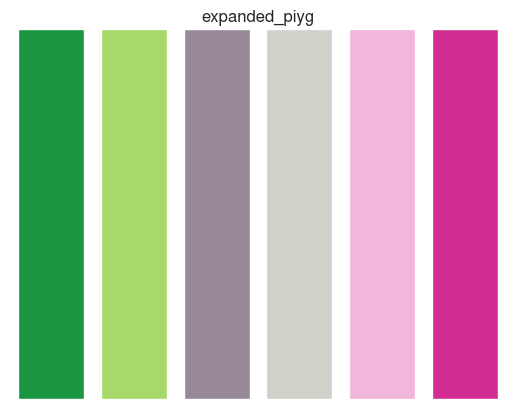

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [64]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)


# Output

In [117]:
output_dir = '/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_graphs/gt_tracks_3.5'
os.makedirs(output_dir, exist_ok = True)

# How many cells are truly permissive ie deltaMtb>0

#### What do the different distributions of deltaMtb look like?

In [102]:
df_delta_mtb = df.drop_duplicates(subset=['delta Mtb raw', 'delta Mtb max raw','delta Mtb max smooth', 'delta Mtb max fold-change'])
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb
0,0,723.909912,33.010132,3648.505957,166.371064,1.0,1.0,1.0,23203.0,357.706421,...,1.642281e+00,0.967023,0.0,WT,CTRL,EC0,423,"(3, 5)",423.3.5,0.001214
75,0,1182.075928,41.261177,5957.662676,207.956332,1.0,1.0,1.0,46389.0,337.410736,...,4.048010e-02,0.816728,0.0,WT,CTRL,EC0,414,"(3, 5)",414.3.5,0.010806
150,0,309.628235,695.610535,1560.526304,3505.877095,0.0,0.0,1.0,37692.0,372.613586,...,4.563279e+00,0.920427,0.0,WT,CTRL,EC0,415,"(3, 5)",415.3.5,0.000342
200,0,392.193390,21.473856,1976.654685,108.228234,0.0,0.0,0.0,25137.0,341.332947,...,0.000000e+00,0.882612,0.0,WT,CTRL,EC0,416,"(3, 5)",416.3.5,0.000000
268,0,766.184570,3.047385,3861.570234,15.358821,1.0,1.0,1.0,3361.0,400.156799,...,-2.918956e-14,0.977825,0.0,WT,CTRL,EC0,417,"(3, 5)",417.3.5,-0.000298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46931,70,472.777283,769.450989,2382.797505,3878.032983,0.0,0.0,1.0,10735.0,362.496216,...,1.209485e+00,0.841202,0.0,WT,CTRL,EC0,3745,"(3, 5)",3745.3.5,0.000126
46936,70,1192.591797,844.759949,6010.662656,4257.590142,1.0,1.0,1.0,7823.0,786.873169,...,5.410034e-01,0.791064,0.0,WT,CTRL,EC0,3738,"(3, 5)",3738.3.5,0.000092
46941,70,1172.863159,878.495789,5911.230322,4427.618774,1.0,1.0,1.0,42129.0,680.945557,...,-5.343842e-01,0.619994,0.0,WT,CTRL,EC0,3734,"(3, 5)",3734.3.5,-0.000024
46954,71,747.637817,986.235657,3768.094600,4970.627710,0.0,0.0,1.0,8869.0,378.876190,...,-1.973273e-15,0.880413,0.0,WT,CTRL,EC0,3765,"(3, 5)",3765.3.5,-0.000051


In [103]:
# drop errant value
df_delta_mtb = df_delta_mtb.drop(20344)

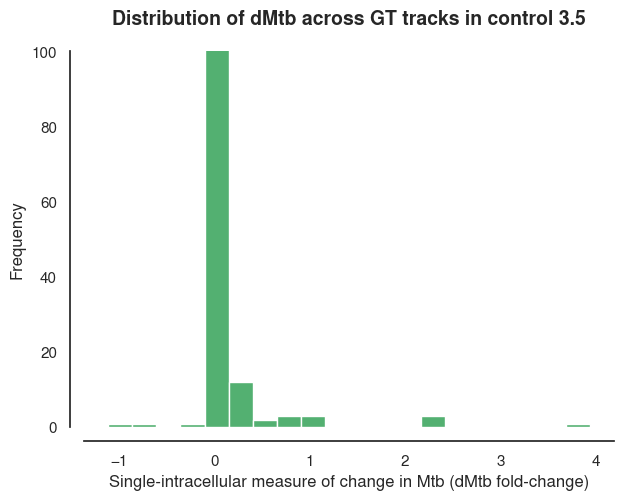

In [119]:
sns.histplot(data=df_delta_mtb, x='dMtb', kde=False, bins = 20, color=expanded_piyg[0])
sns.despine(offset=10)
plt.ylim(0,100)
plt.tight_layout()

plt.ylabel('Frequency')
plt.title('Distribution of dMtb across GT tracks in control 3.5', 
                   fontsize=14, fontweight='bold', 
                  y = 1.05)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')

plt.savefig(os.path.join(output_dir, 'delta_mtb_norm_hist_clipped.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 

In [105]:
# "Melt" the DataFrame to "long-form" or "tidy" representation
df_melted = pd.melt(df_delta_mtb, ["Compound", "Strain"], var_name="measurement")
df_melted = df_melted[df_melted['measurement'] == 'dMtb']
# Rename the 'value' column to 'dMtb'
df_melted = df_melted.rename(columns={'value': 'dMtb'})



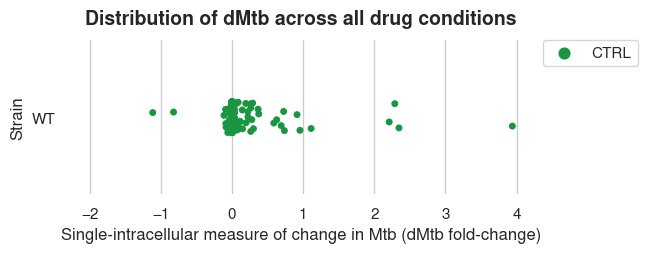

In [118]:
# Initialize the figure
f, ax = plt.subplots(figsize=(6,2))


# Show each observation with a scatterplot
sns.stripplot(
    data=df_melted, x="dMtb", y="Strain", hue="Compound",
    dodge=True, alpha=1, zorder=5, ax=ax, palette = expanded_piyg
)

# Move the legend outside the plot on the right-hand side
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
sns.despine(offset=10, 
            bottom=True, 
            left=True
           )
# # Show the conditional means using pointplot
# sns.pointplot(
#     data=df_melted, x="dMtb", y="Concentration", hue="Compound",
#     join=False, 
#     dodge=.8 - .8 / len(df_delta_mtb['Compound'].unique()), 
#     palette=expanded_piyg,
#     markers="d", scale=.75, errorbar=None, ax=ax, legend = None
# )
# Add vertical lines
vertical_lines = np.linspace(-2,4, 7)  # Example values, modify according to your needs
for line in vertical_lines:
    plt.axvline(x=line, color='black', linestyle='-', linewidth=1, alpha = 0.2)
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', 
                  y = 1.05)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')

plt.savefig(os.path.join(output_dir, 'delta_mtb_scatter.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 

In [113]:
# Assuming 'df_delta_Mtb' is your DataFrame
top_rows = df_delta_mtb.nlargest(7, 'dMtb')

top_rows

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb
41394,38,565.333984,203.120865,2849.283281,1023.729159,0.0,0.0,1.0,19826.0,388.630585,...,85.173329,0.747863,0.0,WT,CTRL,EC0,2671,"(3, 5)",2671.3.5,3.940612
12840,0,933.322388,697.360840,4703.944834,3514.698633,0.0,0.0,1.0,18897.0,377.389099,...,11.976203,0.827378,0.0,WT,CTRL,EC0,106,"(3, 5)",106.3.5,2.346850
10339,0,1013.018066,613.704102,5105.611055,3093.068672,0.0,0.0,1.0,33571.0,390.042694,...,6.309599,0.856875,0.0,WT,CTRL,EC0,484,"(3, 5)",484.3.5,2.288280
11108,0,907.020264,626.401550,4571.382129,3157.063813,0.0,0.0,1.0,14859.0,380.547668,...,9.452961,0.487975,0.0,WT,CTRL,EC0,539,"(3, 5)",539.3.5,2.209745
5618,0,992.732239,347.671783,5003.370483,1752.265789,0.0,0.0,1.0,13415.0,386.294830,...,8.448170,0.910495,0.0,WT,CTRL,EC0,362,"(3, 5)",362.3.5,1.112205
15230,0,365.061066,808.401245,1839.907771,4074.342275,0.0,0.0,1.0,22852.0,353.475372,...,1.134492,0.564495,0.0,WT,CTRL,EC0,128,"(3, 5)",128.3.5,0.955472
44278,46,39.902500,1176.222656,201.108601,5928.162188,0.0,0.0,1.0,11133.0,344.876770,...,9.792017,0.850646,0.0,WT,CTRL,EC0,3033,"(3, 5)",3033.3.5,0.914483


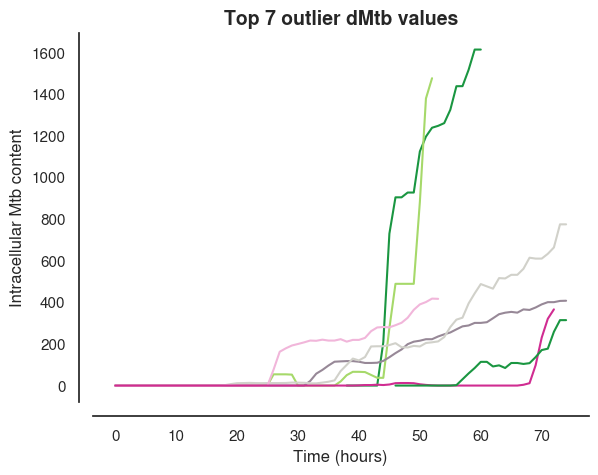

In [114]:
for i, unique_ID in enumerate(top_rows['Unique ID']):
    subset_df = df[df['Unique ID']==unique_ID]
    strain = subset_df['Strain'].iloc[0]
    compound = subset_df['Compound'].iloc[0]
    concentration = subset_df['Concentration'].iloc[0]
    ID = subset_df['Unique ID'].iloc[0]
    label = f'{strain},{compound},{concentration},{ID}'
#     label = f'{ID}'

    gradient = subset_df['delta Mtb/dt'].iloc[0]
#     if gradient<0:
#         continue
    x,y = subset_df['Time (hours)'].iloc[-1], subset_df['Intracellular thresholded Mtb content smooth'].iloc[-1]
#     plt.text(x = x+0.5, y = y-100, s = f'ID:{label}\ndMtb/dt:{gradient:.0f},dMtb:{subset_df.dMtb.iloc[0]:.2f}', size =9)

    sns.lineplot(data = subset_df, 
                 y = 'Intracellular thresholded Mtb content smooth', 
                 x = 'Time (hours)', 
#                  label = label
                 )
sns.despine(offset=10)
plt.title('Top 7 outlier dMtb values', 
               fontsize=14, fontweight='bold', )
#                   y = 1.05)
plt.ylabel('Intracellular Mtb content')
# plt.xlim(24,74)
# plt.text(x = 10, y = 500, s = f'Gradient of Mtb = {gradient}')
plt.savefig(os.path.join(output_dir, 'top7_dmtb_plot.png'), 
           bbox_inches = 'tight', dpi = 314)